# **Practice**

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score,train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score, confusion_matrix, classification_report, auc, roc_auc_score, roc_curve
from scipy.stats import uniform,loguniform,randint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Create data

In [2]:
X,y = make_classification(n_samples=1000,n_classes=2,n_features=10,n_clusters_per_class=4,n_informative=4)

Split data

In [3]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

Scale data for pca

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

Apply PCA to visualize the data

In [5]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

In [6]:
X_train_pca.shape
y_train.shape

(800,)

Scatter plot the data to visualize

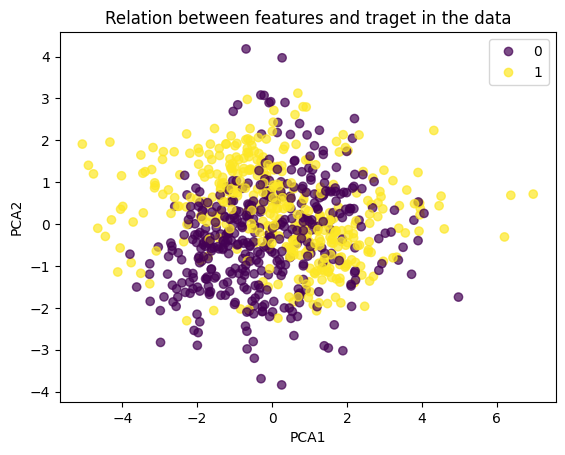

In [7]:
scatter = plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c=y_train,cmap='viridis',alpha=0.7)
legend = plt.legend(scatter.legend_elements()[0], scatter.legend_elements()[1], loc='upper right')
plt.title("Relation between features and traget in the data")
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

Data follow a non-linear relationship

Decision Tree

In [8]:
def train_model(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    # print(f"Accuracy of {type(model).__name__} is {accuracy_score(y_test,y_pred)}")
    return y_pred

In [9]:
models = [DecisionTreeClassifier(),RandomForestClassifier(),SVC()]
for model in models:
    train_model(model)

In [10]:
def evaluate_models(name,y_pred):
    print(f'''Evaluation scores for {name}\n
Accuracy is {accuracy_score(y_pred,y_test)}\n
precision is {precision_score(y_pred,y_test)}\n
recall is {recall_score(y_pred,y_test)}\n
confussion matrix: \n{confusion_matrix(y_test,y_pred)}\n
classification report: \n{classification_report(y_test,y_pred)}\n
''')

In [11]:
for model in models:
    y_pred = train_model(model)
    evaluate_models(type(model).__name__,y_pred)

Evaluation scores for DecisionTreeClassifier

Accuracy is 0.72

precision is 0.6730769230769231

recall is 0.7608695652173914

confussion matrix: 
[[74 22]
 [34 70]]

classification report: 
              precision    recall  f1-score   support

           0       0.69      0.77      0.73        96
           1       0.76      0.67      0.71       104

    accuracy                           0.72       200
   macro avg       0.72      0.72      0.72       200
weighted avg       0.72      0.72      0.72       200



Evaluation scores for RandomForestClassifier

Accuracy is 0.795

precision is 0.7788461538461539

recall is 0.8181818181818182

confussion matrix: 
[[78 18]
 [23 81]]

classification report: 
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        96
           1       0.82      0.78      0.80       104

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.79       200
weighted avg    

**Hyperparameter Tuning**

In [12]:
def hyperparameter_tuning(model,param_dis):
    random_seach_cv = RandomizedSearchCV(estimator=model,param_distributions=param_dis,cv=5,n_iter=50)
    random_seach_cv.fit(X_train,y_train)
    best_params = random_seach_cv.best_params_
    # print(best_params)
    # print(random_seach_cv.best_estimator_)
    # print(random_seach_cv.best_score_)
    param_grid = {}
    for param in param_dis:
        param_value = best_params[param]
        if isinstance(param_dis[param], list):
            param_grid[param] = list(range(max(1, param_value - 2), param_value + 3))
        elif isinstance(param_dis[param], stats._distn_infrastructure.rv_frozen):
            param_grid[param] = np.linspace(param_value - 2, param_value + 2, num=5,dtype=int).tolist()

    # print(param_grid)
    grid_cv =  GridSearchCV(estimator=model,param_grid=param_grid,cv=5)
    grid_cv.fit(X_train,y_train)
    # print(grid_cv.best_score_)
    return grid_cv.best_estimator_

In [13]:
param_dis = {'max_depth': randint(5, 20),
            'min_samples_split': randint(2, 10),
            'min_samples_leaf': randint(2, 20),
            }
hyperparameter_tuning(DecisionTreeClassifier(), param_dis=param_dis)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=20)

### AUC, ROC, and the AUC-ROC Curve

These metrics are essential tools for evaluating the performance of classification models, especially when your classes are imbalanced or when you care more about ranking predictions than precise class assignments.

**ROC(Receiver Operating Characteristic)**

* The ROC curve is a graphical representation of a classifier's performance across different classification thresholds.
* It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold levels.

* True Positive Rate(TPR): Ratio of correctly classified +ve points from actual +ve points
* False Positive Rate(FPR): This tells us what fraction of negative cases were incorrectly classified as positive.

The ROC curve helps visualize the trade-off between TPR and FPR as we vary the decision threshold. At one extreme (e.g., threshold = 0), the model predicts all examples as positive, leading to high TPR and high FPR. At the other extreme (e.g., threshold = 1), the model predicts all examples as negative, leading to low TPR and low FPR.

**AUC (Area Under the Curve)**

AUC stands for the Area Under the Curve of the ROC plot.

* It is a single scalar value that summarizes the performance of a model across all possible thresholds.
* AUC provides an aggregate measure of the model's ability to discriminate between positive and negative classes.

* AUC = 1.0: Perfect classifier (ideal scenario).
* AUC = 0.5: The classifier performs no better than random guessing (like flipping a coin).
* AUC < 0.5: The model is worse than random guessing (likely something is wrong with the model).

* Imbalanced Datasets: Metrics like accuracy can be misleading when one class dominates. ROC-AUC focuses on the ranking of predictions rather than exact classifications.
* Threshold Selection: ROC curves help you choose an optimal threshold that balances sensitivity (TPR) and specificity (1 - FPR).

**AUC-ROC Curve**

* A model that perfectly separates positive and negative classes will have a curve that hugs the top-left corner of the plot.
* A poor model will have a curve close to the diagonal line, indicating random performance.

AUC: 0.9231368186874305


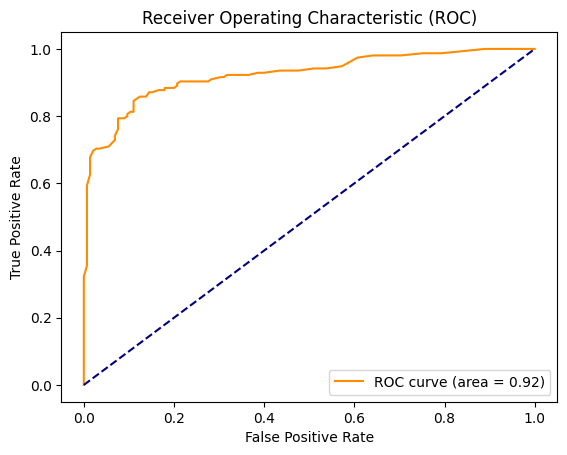

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# Create synthetic data
X, y = make_classification(n_samples=1000, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predict probabilities
y_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")


plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [15]:
thresholds

array([2.  , 1.  , 0.99, 0.97, 0.96, 0.94, 0.93, 0.92, 0.91, 0.9 , 0.89,
       0.88, 0.87, 0.86, 0.84, 0.83, 0.81, 0.8 , 0.79, 0.78, 0.77, 0.76,
       0.75, 0.74, 0.72, 0.71, 0.68, 0.62, 0.6 , 0.58, 0.56, 0.55, 0.54,
       0.53, 0.51, 0.46, 0.44, 0.42, 0.4 , 0.39, 0.36, 0.35, 0.34, 0.32,
       0.31, 0.29, 0.27, 0.24, 0.23, 0.22, 0.21, 0.2 , 0.19, 0.18, 0.17,
       0.16, 0.15, 0.14, 0.13, 0.12, 0.11, 0.1 , 0.09, 0.08, 0.07, 0.06,
       0.05, 0.03, 0.02, 0.01, 0.  ])

In [16]:
fpr

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00689655, 0.00689655, 0.00689655, 0.00689655,
       0.00689655, 0.00689655, 0.00689655, 0.00689655, 0.00689655,
       0.0137931 , 0.0137931 , 0.0137931 , 0.02068966, 0.02758621,
       0.03448276, 0.05517241, 0.06896552, 0.06896552, 0.07586207,
       0.07586207, 0.07586207, 0.08965517, 0.09655172, 0.09655172,
       0.10344828, 0.11034483, 0.11034483, 0.11034483, 0.11034483,
       0.12413793, 0.13793103, 0.14482759, 0.15172414, 0.16551724,
       0.17931034, 0.17931034, 0.1862069 , 0.2       , 0.20689655,
       0.20689655, 0.2137931 , 0.25517241, 0.27586207, 0.28275862,
       0.30344828, 0.31034483, 0.31724138, 0.33103448, 0.36551724,
       0.3862069 , 0.4       , 0.43448276, 0.47586207, 0.51034483,
       0.53793103, 0.57241379, 0.60689655, 0.64137931, 0.70344828,
       0.75172414, 0.79310345, 0.88965517, 0.96551724, 0.97931034,
       1.        ])

## **Hyperparameter tuning**

Hyperparameters: These are set before the training begins. Examples include:

* The maximum depth of a decision tree.
* The learning rate for gradient descent.
* The number of hidden layers in a neural network.

Grid Search is a systematic way of finding the best combination of hyperparameters for your model. Think of it like this: you have a grid, where each cell represents a combination of hyperparameters, and you’re testing every single cell to see which one gives the best performance.

In [17]:
params = {
    'max_depth': [5,7,10,15],
    'min_samples_split': [2,5,7],
    'min_samples_leaf': [5,7,10]
}

In [18]:
grid_cv = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),param_grid=params,scoring='roc_auc',cv=5,verbose=1)
grid_cv.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [5, 7, 10, 15],
                         'min_samples_leaf': [5, 7, 10],
                         'min_samples_split': [2, 5, 7]},
             scoring='roc_auc', verbose=1)

In [19]:
print("Best Parameters:", grid_cv.best_params_)
print("Best Score:", grid_cv.best_score_)

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 2}
Best Score: 0.9372116758522147


In [20]:
p = grid_cv.predict(X_test)
accuracy_score(p,y_test)

0.8766666666666667

**RandomSearchCV**

Why Do We Need Randomized Search?
To recap from our last lecture, Grid Search involves evaluating all possible combinations of hyperparameters from a predefined grid. However, this approach has two major drawbacks:

* Computational Expense:
As the number of hyperparameters and their possible values increase, the search space grows exponentially. For instance, if you have 3 hyperparameters with 10 possible values each, that’s 10 × 10 × 10 = 1000 combinations.

* Inefficiency in High Dimensions:
Not all hyperparameters are equally important. Often, only a few have a significant impact on the model’s performance. Grid Search spends a lot of time exploring combinations that don’t matter.
RandomizedSearchCV addresses these issues by randomly sampling hyperparameter combinations instead of exhaustively searching the entire grid.


Randomized Search is a technique where you:

* Specify a range or distribution for each hyperparameter.
* Randomly sample a fixed number of combinations from this space.
* Evaluate each combination using cross-validation.

In [21]:
param_dis = {'max_depth': randint(5, 20),
          'min_samples_split': randint(2, 10),
          'min_samples_leaf': randint(2, 20),
          }

In [22]:
random_seach_cv = RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),param_distributions=param_dis,n_iter=50,cv=5,scoring='accuracy')
random_seach_cv.fit(X_train,y_train)
print(f"Best parameter: {random_seach_cv.best_params_}")
print(f"Best Score: {random_seach_cv.best_score_}")

Best parameter: {'max_depth': 5, 'min_samples_leaf': 17, 'min_samples_split': 4}
Best Score: 0.9014285714285715


##

In [23]:
import pickle,joblib

In [24]:
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [25]:
with open('decision_tree.pkl','wb') as f:
    pickle.dump(tree,f)

In [26]:
with open('decision_tree.pkl','rb') as f:
    model = pickle.load(f)

In [27]:
joblib.dump(model, 'model.joblib')


['model.joblib']

In [28]:
joblib.load('model.joblib')

DecisionTreeClassifier()